## **Problem B: Serendipity in Recommender systems**

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import math
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.linalg import svd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import cvxpy as cp
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#### Methods 

In [ ]:
def jaccard_similarity(list1, list2):
    """
    Function that computes jaccard similarity,
    that is the ratio of the sizes of the intersection and union of 2 sets A and B.
    The formula is:
        |A intersection B|/|A union B|
    """

    intersection = np.intersect1d(list1, list2)
    union = np.union1d(list1, list2)
    return (len(intersection)/ len(union))

def filter_df(df_to_get_unique_ids, df_to_be_filtered):
    uniqueviewedmovies = np.sort(df_to_get_unique_ids['movieId'].unique())
    selected = df_to_be_filtered[df_to_be_filtered.movieId.isin(uniqueviewedmovies)]
    selected.reset_index(inplace=True)
    return selected

    
def filter_users(answersdf, threshold):
    # count occurances of userId in answersdf
    series = answersdf.groupby(['userId'])['userId'].count()
    # filter only those users that have rated more than 'threshold' movies
    filtered_answersdf = answersdf[answersdf.userId.isin(series.where(series > threshold).dropna().index)]
    return filtered_answersdf

def filter_movies(answersdf, threshold):
    # count occurances of movieId in answersdf
    series = answersdf.groupby(['movieId'])['movieId'].count()
    # filter only those movies that are rated more than 'threshold' users
    filtered_answersdf = answersdf[answersdf.movieId.isin(series.where(series > threshold).dropna().index)]
    return filtered_answersdf

def item_item_cosine_similarity(ratings_df):
    ratings_matrix = np.asarray(ratings_df)
    A_sparse = sparse.csr_matrix(ratings_matrix)
    similarities = cosine_similarity(A_sparse.T, dense_output=True)
    return similarities

#### Read Datasets: answers.csv and movies.csv

In [ ]:
moviecolumns = ['movieId', 'title', 'directedBy', 'starring', 'genres']
moviesdf = pd.read_csv('movies.csv', usecols=moviecolumns, keep_default_na=False)
answerscolumns = ['userId', 'movieId', 'rating','timestamp', 'predictedRating', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8','s_ser_rel','s_ser_find','s_ser_imp','s_ser_rec','m_ser_rel','m_ser_find','m_ser_imp', 'm_ser_rec']
answersdf = pd.read_csv('answers.csv', usecols=answerscolumns)

In [ ]:
answersdf.head()

,userId,movieId,rating,timestamp,predictedRating,s1,s2,s3,s4,s5,s6,s7,s8,s_ser_rel,s_ser_find,s_ser_imp,s_ser_rec,m_ser_rel,m_ser_find,m_ser_imp,m_ser_rec
0,205229,108979,5.0,1486127833000,4.882299,1.0,1.0,3.0,4.0,2.0,2.0,5.0,5.0,False,False,False,False,False,False,False,False
1,205229,6947,4.0,1486121212000,3.253348,1.0,1.0,3.0,4.0,4.0,2.0,5.0,4.0,False,False,False,False,False,False,False,False
2,205229,117444,4.0,1486127837000,4.922837,1.0,4.0,4.0,2.0,2.0,2.0,4.0,2.0,False,False,False,False,False,False,False,False
3,205229,150548,4.0,1486127824000,4.428912,2.0,2.0,4.0,2.0,4.0,2.0,4.0,1.0,False,False,False,False,False,False,False,False
4,205229,136542,5.0,1486128075000,4.101256,1.0,1.0,5.0,1.0,1.0,2.0,5.0,2.0,False,False,False,False,False,False,False,False


###  Data Preprocessing
---

In [ ]:
# filter dataframe answersdf
columns_to_be_filtered_for_na = ['predictedRating','s5', 's6','s7']
filtered_answersdf = answersdf.dropna(subset=columns_to_be_filtered_for_na)
filtered_answersdf = filter_movies(filtered_answersdf,1) # threshold=1
filtered_answersdf = filter_users(filtered_answersdf, 1) # threshold=1

# -- START
# TO USE TAG GENOME FEATURE, UNCOMMENT THE FOLLOWING FOUR LINES
# filtered_tagdf = filter_df(filtered_answersdf, taggenomedf)
# filtered_answersdf = filter_df(filtered_tagdf, filtered_answersdf)
# filtered_answersdf = filter_movies(filtered_answersdf,1) # threshold=1
# filtered_answersdf = filter_users(filtered_answersdf, 1) # threshold=1
# -- END

# filter dataframe moviesdf
filtered_moviesdf = filter_df(filtered_answersdf, moviesdf)

Keep users that rated more than 1 movie

In [ ]:
filtered_answersdf.userId.value_counts()

127480    5
113138    5
143272    5
143912    5
140928    5
         ..
100998    2
145032    2
118409    2
198287    2
201672    2
Name: userId, Length: 208, dtype: int64

In [ ]:
print("Number of unique movies in filtered_answersdf: ",filtered_answersdf.movieId.unique().size )
print("Number of unique users in filtered_answersdf: ",filtered_answersdf.userId.unique().size )

Number of unique movies in filtered_answersdf:  229
Number of unique users in filtered_answersdf:  208


### Feature Engineering for Serendipity Prediction Model

---
1.   Genre-based similarity user x movie profile
2.   Tag-based similarity user x movie profile (optional feature)
2.   Movie Popularity
3.   Predicted Rating




### 1.   Genre-based similarity user x movie profile

**A. Compute Genre-based similarity (Jaccard Similarity in genres attributes)**

In [ ]:
similarity_matrix = np.zeros([filtered_moviesdf['genres'].size,filtered_moviesdf['genres'].size])

In [ ]:
for i in range(filtered_moviesdf['genres'].size):
        movie_i = filtered_moviesdf['movieId'][i]
        for j in range(filtered_moviesdf['genres'].size):
            similarity_matrix[i][j] = round(jaccard_similarity(list(filtered_moviesdf['genres'][i].split(',')),list(filtered_moviesdf['genres'][j].split(','))), 3)

In [ ]:
# similarity_matrix = np.load('similarity_matrix.npy')

Convert similarity matrix to Dataframe

In [ ]:
sim_content_df = pd.DataFrame(similarity_matrix, index = filtered_moviesdf.movieId, columns=filtered_moviesdf['movieId'])
sim_content_df.head()

movieId,135,215,293,532,600,906,1214,1216,1246,1270,1416,1518,1729,1747,1889,2143,2161,2186,2360,2579,2700,2804,2810,2905,3994,3996,5464,6271,6509,6639,6708,6787,7206,7216,7324,7482,7618,7981,8752,8874,...,164179,164367,164540,164909,164917,164931,164949,164981,165105,165141,165337,165347,165421,165483,165549,165551,165937,166024,166149,166461,166486,166528,166558,166568,166635,166643,166705,166788,166918,166946,167018,167036,167038,167370,167544,167570,168026,168040,169912,170705
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135,1.000,0.0,0.000,0.333,0.333,0.000,0.00,0.000,0.00,0.333,0.000,0.00,0.00,1.000,0.00,0.00,0.0,0.000,0.00,0.0,0.333,0.50,0.000,0.00,0.000,0.000,0.000,0.333,0.0,0.000,0.333,0.000,1.000,0.000,0.000,0.000,0.00,0.00,0.000,0.500,...,0.0,0.000,0.0,0.333,0.0,0.000,0.00,0.000,0.00,0.0,0.00,0.000,0.0,1.000,0.00,0.00,0.00,0.0,0.00,0.200,0.00,0.000,0.00,0.00,0.000,0.00,0.00,0.00,0.0,0.00,1.000,0.333,0.0,0.000,0.000,0.0,0.000,0.0,1.000,0.00
215,0.000,1.0,0.200,0.000,0.000,0.333,0.00,0.667,0.50,0.000,0.333,0.00,0.25,0.000,0.25,0.25,0.0,0.200,0.50,0.0,0.000,0.00,0.000,0.25,0.333,0.667,0.333,0.667,1.0,0.333,0.250,0.333,0.000,0.200,0.333,0.000,0.50,0.25,0.667,0.000,...,0.0,0.200,0.0,0.667,0.0,0.333,0.50,0.400,0.00,0.0,0.50,0.167,0.0,0.000,0.50,0.50,0.50,0.0,0.50,0.000,0.50,0.000,0.00,0.00,0.500,0.50,0.50,0.50,0.0,0.50,0.000,0.000,1.0,0.000,0.333,0.0,0.000,0.0,0.000,0.25
293,0.000,0.2,1.000,0.167,0.400,0.500,0.00,0.167,0.25,0.000,0.200,0.50,0.75,0.000,0.40,0.00,0.0,0.600,0.25,0.4,0.000,0.00,0.143,0.40,0.200,0.400,0.500,0.167,0.2,0.500,0.400,0.500,0.000,0.600,0.200,0.500,0.25,0.75,0.167,0.000,...,0.0,0.333,0.0,0.167,0.0,0.500,0.25,0.500,0.20,0.0,0.25,0.800,0.0,0.000,0.25,0.25,0.25,0.0,0.25,0.000,0.25,0.143,0.20,0.25,0.143,0.25,0.25,0.25,0.4,0.25,0.000,0.000,0.2,0.167,0.500,0.0,0.143,0.0,0.000,0.40
532,0.333,0.0,0.167,1.000,0.500,0.000,0.25,0.000,0.00,0.200,0.000,0.00,0.20,0.333,0.00,0.00,0.0,0.167,0.00,0.2,0.200,0.25,0.167,0.00,0.000,0.000,0.250,0.200,0.0,0.000,0.500,0.000,0.333,0.167,0.000,0.250,0.00,0.20,0.000,0.667,...,0.0,0.167,0.0,0.200,0.0,0.000,0.00,0.000,0.25,0.0,0.00,0.143,0.0,0.333,0.00,0.00,0.00,0.0,0.00,0.143,0.00,0.000,0.25,0.00,0.000,0.00,0.00,0.00,0.0,0.00,0.333,0.200,0.0,0.000,0.000,0.0,0.000,0.0,0.333,0.00
600,0.333,0.0,0.400,0.500,1.000,0.000,0.00,0.000,0.00,0.200,0.000,0.25,0.20,0.333,0.00,0.00,0.0,0.167,0.00,0.2,0.200,0.25,0.000,0.20,0.000,0.200,0.250,0.200,0.0,0.000,0.500,0.000,0.333,0.167,0.000,0.667,0.00,0.20,0.000,0.250,...,0.0,0.000,0.0,0.200,0.0,0.000,0.00,0.143,0.00,0.0,0.00,0.333,0.0,0.333,0.00,0.00,0.00,0.0,0.00,0.143,0.00,0.167,0.25,0.00,0.000,0.00,0.00,0.00,0.2,0.00,0.333,0.200,0.0,0.200,0.000,0.0,0.167,0.0,0.333,0.20


Compute Dissimilarity Matrix

In [ ]:
dissim_matrix = 1-similarity_matrix
dissim_content_df = pd.DataFrame(dissim_matrix, index = filtered_moviesdf.movieId, columns=filtered_moviesdf['movieId'])
dissim_content_df.head()

movieId,135,215,293,532,600,906,1214,1216,1246,1270,1416,1518,1729,1747,1889,2143,2161,2186,2360,2579,2700,2804,2810,2905,3994,3996,5464,6271,6509,6639,6708,6787,7206,7216,7324,7482,7618,7981,8752,8874,...,164179,164367,164540,164909,164917,164931,164949,164981,165105,165141,165337,165347,165421,165483,165549,165551,165937,166024,166149,166461,166486,166528,166558,166568,166635,166643,166705,166788,166918,166946,167018,167036,167038,167370,167544,167570,168026,168040,169912,170705
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135,0.000,1.0,1.000,0.667,0.667,1.000,1.00,1.000,1.00,0.667,1.000,1.00,1.00,0.000,1.00,1.00,1.0,1.000,1.00,1.0,0.667,0.50,1.000,1.00,1.000,1.000,1.000,0.667,1.0,1.000,0.667,1.000,0.000,1.000,1.000,1.000,1.00,1.00,1.000,0.500,...,1.0,1.000,1.0,0.667,1.0,1.000,1.00,1.000,1.00,1.0,1.00,1.000,1.0,0.000,1.00,1.00,1.00,1.0,1.00,0.800,1.00,1.000,1.00,1.00,1.000,1.00,1.00,1.00,1.0,1.00,0.000,0.667,1.0,1.000,1.000,1.0,1.000,1.0,0.000,1.00
215,1.000,0.0,0.800,1.000,1.000,0.667,1.00,0.333,0.50,1.000,0.667,1.00,0.75,1.000,0.75,0.75,1.0,0.800,0.50,1.0,1.000,1.00,1.000,0.75,0.667,0.333,0.667,0.333,0.0,0.667,0.750,0.667,1.000,0.800,0.667,1.000,0.50,0.75,0.333,1.000,...,1.0,0.800,1.0,0.333,1.0,0.667,0.50,0.600,1.00,1.0,0.50,0.833,1.0,1.000,0.50,0.50,0.50,1.0,0.50,1.000,0.50,1.000,1.00,1.00,0.500,0.50,0.50,0.50,1.0,0.50,1.000,1.000,0.0,1.000,0.667,1.0,1.000,1.0,1.000,0.75
293,1.000,0.8,0.000,0.833,0.600,0.500,1.00,0.833,0.75,1.000,0.800,0.50,0.25,1.000,0.60,1.00,1.0,0.400,0.75,0.6,1.000,1.00,0.857,0.60,0.800,0.600,0.500,0.833,0.8,0.500,0.600,0.500,1.000,0.400,0.800,0.500,0.75,0.25,0.833,1.000,...,1.0,0.667,1.0,0.833,1.0,0.500,0.75,0.500,0.80,1.0,0.75,0.200,1.0,1.000,0.75,0.75,0.75,1.0,0.75,1.000,0.75,0.857,0.80,0.75,0.857,0.75,0.75,0.75,0.6,0.75,1.000,1.000,0.8,0.833,0.500,1.0,0.857,1.0,1.000,0.60
532,0.667,1.0,0.833,0.000,0.500,1.000,0.75,1.000,1.00,0.800,1.000,1.00,0.80,0.667,1.00,1.00,1.0,0.833,1.00,0.8,0.800,0.75,0.833,1.00,1.000,1.000,0.750,0.800,1.0,1.000,0.500,1.000,0.667,0.833,1.000,0.750,1.00,0.80,1.000,0.333,...,1.0,0.833,1.0,0.800,1.0,1.000,1.00,1.000,0.75,1.0,1.00,0.857,1.0,0.667,1.00,1.00,1.00,1.0,1.00,0.857,1.00,1.000,0.75,1.00,1.000,1.00,1.00,1.00,1.0,1.00,0.667,0.800,1.0,1.000,1.000,1.0,1.000,1.0,0.667,1.00
600,0.667,1.0,0.600,0.500,0.000,1.000,1.00,1.000,1.00,0.800,1.000,0.75,0.80,0.667,1.00,1.00,1.0,0.833,1.00,0.8,0.800,0.75,1.000,0.80,1.000,0.800,0.750,0.800,1.0,1.000,0.500,1.000,0.667,0.833,1.000,0.333,1.00,0.80,1.000,0.750,...,1.0,1.000,1.0,0.800,1.0,1.000,1.00,0.857,1.00,1.0,1.00,0.667,1.0,0.667,1.00,1.00,1.00,1.0,1.00,0.857,1.00,0.833,0.75,1.00,1.000,1.00,1.00,1.00,0.8,1.00,0.667,0.800,1.0,0.800,1.000,1.0,0.833,1.0,0.667,0.80


**B. Compute user x movie genre-based similarity profile (sim_prof_ui)**

In [ ]:
sim_matrix_df = sim_content_df 
sim_prof_ui = pd.DataFrame(columns=('userId','movieId','sim_prof_ui') )
index = -1
unique_users = filtered_answersdf.userId.unique()
for user in unique_users:
    movies_u = filtered_answersdf[filtered_answersdf.userId==user]['movieId']
    for movie_i in movies_u:
        index = index + 1
        similarity_ij = 0
        for movie_j in movies_u:
            if movie_i != movie_j:
                similarity_ij = similarity_ij + sim_matrix_df.loc[int(movie_i), int(movie_j)]
            
        sim_prof_ui.loc[index] = [user, movie_i,similarity_ij/(len(movies_u))]       
sim_prof_ui.head()

,userId,movieId,sim_prof_ui
0,205229.0,108979.0,0.125
1,205229.0,150548.0,0.125
2,116352.0,164179.0,0.000
3,116352.0,164981.0,0.111
4,116352.0,162606.0,0.111


### 2. Tag-based similarity user x movie profile

**A. Compute tag-based similarity (cosine similarity in relevance scores)**

In [ ]:
tag_df = filtered_tagdf.pivot(index='movieId', columns='tag', values='relevance')
tag_sim_matrix = item_item_cosine_similarity(tag_df.T)
tag_sim_matrix

In [ ]:
tag_sim_df = pd.DataFrame(tag_sim_matrix, index = tag_df.index, columns=tag_df.index)
tag_sim_df.head()

B. Compute tag-based users x movies similarity profile

In [ ]:
# Choose similarity matrix
tag_sim_matrix_df = tag_sim_df 
tag_sim_prof_ui = pd.DataFrame(columns=('userId','movieId','tag_sim_prof_ui') )
index = -1
unique_users = filtered_answersdf.userId.unique()
for user in unique_users:
    movies_u = filtered_answersdf[filtered_answersdf.userId==user]['movieId']
    #print("Movies u: ", movies_u)
    for movie_i in movies_u:
        index = index + 1
        tag_similarity_ij = 0
        for movie_j in movies_u:
            if movie_i != movie_j:
                tag_similarity_ij = tag_similarity_ij + tag_sim_matrix_df.loc[int(movie_i), int(movie_j)]
     #           print("Movie_i :", movie_i, " has :", tag_sim_matrix_df.loc[int(movie_i), int(movie_j)])
            
        tag_sim_prof_ui.loc[index] = [user, movie_i,tag_similarity_ij/(len(movies_u))]   
tag_sim_prof_ui.head()

### 3. Movie Popularity

**Compute log10(Ui) popularity**
* Ui: number of users that have rated item i

In [ ]:
#number_of_users = filtered_answersdf.userId.unique().size
movieId_ratings_occurences = filtered_answersdf.groupby(['movieId'])['movieId'].count()
#pi = movieId_ratings_occurences / number_of_users
pi = movieId_ratings_occurences
print(pi.head())
logpi = np.log10(pi)
print(logpi.head())

movieId
135    2
215    2
293    2
532    1
600    1
Name: movieId, dtype: int64
movieId
135    0.30103
215    0.30103
293    0.30103
532    0.00000
600    0.00000
Name: movieId, dtype: float64


### 4. Predicted Rating
* Provided in answers.csv dataset

## Serendipity Definition

---



We will define the serendipity index as:


*   The average of answers of users to questions s5,s6,s7 ie:
    Si = 1/3(s5 + s6 +s7)
*   The union of attributes : s_ser_find | s_ser_imp | s_ser_rec



In [ ]:
filtered_answersdf['numeric_siu'] = (filtered_answersdf.s5 + filtered_answersdf.s6 + filtered_answersdf.s7) / 3

In [ ]:
filtered_answersdf['serendipity_index'] = filtered_answersdf.s_ser_find.values | filtered_answersdf.s_ser_imp.values | filtered_answersdf.s_ser_rec.values | filtered_answersdf.m_ser_imp.values | filtered_answersdf.m_ser_rec.values 

## Prediction Models
---
1.   Logistic Regression
2.   Random Forest




#### Creating Training and Test Datasets

In [ ]:
siu_df = filtered_answersdf[['userId', 'movieId', 'predictedRating','serendipity_index']]
siu_df['numeric_siu'] = (filtered_answersdf.s5 + filtered_answersdf.s6 + filtered_answersdf.s7) / 3
siu_df['logpi_from_answers_csv'] = logpi[siu_df.movieId].values
siu_df['sim_prof_ui'] = sim_prof_ui.sim_prof_ui.values
# siu_df['tag_sim_prof_ui'] = tag_sim_prof_ui.tag_sim_prof_ui.values
dataset = siu_df[['serendipity_index', 'numeric_siu', 'logpi_from_answers_csv', 'sim_prof_ui','predictedRating']].dropna()
print(dataset.head())

    serendipity_index  numeric_siu  ...  sim_prof_ui  predictedRating
0               False     3.000000  ...        0.125         4.882299
3               False     3.333333  ...        0.125         4.428912
27              False     2.666667  ...        0.000         4.248882
28              False     2.666667  ...        0.111         2.981665
31              False     2.333333  ...        0.111         3.247394

[5 rows x 5 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [ ]:
serendipitous_dataset = dataset[dataset.serendipity_index == True]
print("Serendipitous items in answers.csv :",serendipitous_dataset.serendipity_index.size)
non_serendipitous_dataset = dataset[dataset.serendipity_index == False]
print("Non serendipitous items in answers.csv :",non_serendipitous_dataset.serendipity_index.size)

Serendipitous items in answers.csv : 66
Non serendipitous items in answers.csv : 496


* We can see in the final dataset that the ratio for serendipitous and non serendipitous movies is unbalanced with the serendipitous movies only a few. 

* We suggest to reduce the non serendipitous movies set and the prediction will have more possibilities to learn how to predict serendipity for our dataset.

In [ ]:
# Create balanced dataset
non_serendipitous_upper_bound = round(non_serendipitous_dataset.serendipity_index.size / 5)
new_dataset = pd.concat([serendipitous_dataset, non_serendipitous_dataset[non_serendipitous_upper_bound:2*non_serendipitous_upper_bound]])

In [ ]:
train_data, test_data = train_test_split(new_dataset, shuffle=True, test_size=0.20, random_state = 28)    
print(train_data.serendipity_index.size)
print(train_data.head())

132
      serendipity_index  numeric_siu  ...  sim_prof_ui  predictedRating
687               False     2.666667  ...     0.083500         4.717377
538               False     2.666667  ...     0.500000         4.206936
1244               True     2.333333  ...     0.166500         4.843630
452               False     2.666667  ...     0.233333         4.065119
723                True     4.000000  ...     0.180000         4.704504

[5 rows x 5 columns]


In [ ]:
# Training set
X_train_rf = train_data[['sim_prof_ui','logpi_from_answers_csv','predictedRating']]
y_train_rf = train_data[['numeric_siu']]

X_train_logit_1 = train_data[['sim_prof_ui','logpi_from_answers_csv']]
y_train_logit_1 = train_data[['serendipity_index']]

X_train_logit_2 = train_data[['sim_prof_ui','logpi_from_answers_csv','predictedRating']]
y_train_logit_2 = train_data[['serendipity_index']]

# X_train_logit_3 = train_data[['sim_prof_ui','logpi_from_answers_csv','predictedRating','tag_sim_prof_ui']]
y_train_logit_3 = train_data[['serendipity_index']]

#Test set
X_test_rf = test_data[['sim_prof_ui','logpi_from_answers_csv','predictedRating']]
y_test_rf = test_data[['numeric_siu']]

X_test_logit_1 = test_data[['sim_prof_ui','logpi_from_answers_csv']]
y_test_logit_1 = test_data[['serendipity_index']]

X_test_logit_2 = test_data[['sim_prof_ui','logpi_from_answers_csv','predictedRating']]
y_test_logit_2 = test_data[['serendipity_index']]

# X_test_logit_3 = test_data[['sim_prof_ui','logpi_from_answers_csv','predictedRating','tag_sim_prof_ui']]
y_test_logit_3 = test_data[['serendipity_index']]

**1. Logistic Regression**

A. Logistic Regression with sim_prof_ui and log10Popularity features

In [ ]:
lrc_1 = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train_logit_1,y_train_logit_1.values.ravel())

y_pred_logit_1 = lrc_1.predict(X_test_logit_1)
y_pred_logit_1 = y_pred_logit_1.reshape(len(y_pred_logit_1),1)

logit_results_df_1 = pd.DataFrame({'Actual_siu': y_test_logit_1.values.flatten(), 'Predicted_siu': y_pred_logit_1.flatten()})
logit_results_df_1.head()


print("A. Logistic Regression with sim_prof_ui and log10Popularity features")

# Coefficients
print("\nCoefficients =", lrc_1.coef_)
print("Intercept ",  lrc_1.intercept_)

# R2 Score
print("\nLogistic Regression R2 score on train dataset = ", lrc_1.score(X_train_logit_1, y_train_logit_1.values.ravel()))
print("Logistic Regression R2 score on test dataset = ", lrc_1.score(X_test_logit_1, y_test_logit_1.values.ravel()))

# Errors
print('\nMean Absolute Error:', metrics.mean_absolute_error(y_test_logit_1.values.flatten().astype('uint8'), y_pred_logit_1.flatten().astype('uint8')))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_logit_1.values.flatten().astype('uint8'), y_pred_logit_1.flatten().astype('uint8')))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_logit_1.values.flatten().astype('uint8'), y_pred_logit_1.flatten().astype('uint8'))))

# Precision, accuracy and recall
print('\nAccuracy: ', accuracy_score(y_test_logit_1,y_pred_logit_1))
print('Precision: ', precision_score(y_test_logit_1,y_pred_logit_1))
print('Recall: ', recall_score(y_test_logit_1,y_pred_logit_1))

print("\nItems in train dataset :",y_train_logit_1.values.size)
print("Serendipitous items in train dataset :",y_train_logit_1[y_train_logit_1.values==1].size)
print("\nItems in test dataset :",y_test_logit_1.values.size)
print("Serendipitous items in test dataset :",y_test_logit_1[y_test_logit_1.values==1].size)
print("\nPredicted serendipitous items in test dataset :", logit_results_df_1[logit_results_df_1.Predicted_siu==1].size)

A. Logistic Regression with sim_prof_ui and log10Popularity features

Coefficients = [[-0.26310049 -1.00780813]]
Intercept  [0.18674386]

Logistic Regression R2 score on train dataset =  0.5833333333333334
Logistic Regression R2 score on test dataset =  0.6060606060606061

Mean Absolute Error: 61.96969696969697
Mean Squared Error: 0.3939393939393939
Root Mean Squared Error: 0.6276459144608478

Accuracy:  0.6060606060606061
Precision:  0.2857142857142857
Recall:  0.2

Items in train dataset : 132
Serendipitous items in train dataset : 56

Items in test dataset : 33
Serendipitous items in test dataset : 10

Predicted serendipitous items in test dataset : 14


B. Logistic Regression with sim_prof_ui, log10Popularity and predicted rating features

In [ ]:
lrc_2 = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train_logit_2,y_train_logit_2.values.ravel())

y_pred_logit_2 = lrc_2.predict(X_test_logit_2)
y_pred_logit_2 = y_pred_logit_2.reshape(len(y_pred_logit_2),1)

logit_results_df_2 = pd.DataFrame({'Actual_siu': y_test_logit_2.values.flatten(), 'Predicted_siu': y_pred_logit_2.flatten()})
logit_results_df_2.head()

print("B. Logistic Regression with sim_prof_ui, log10Popularity and predicted rating features")

print("\nCoefficients =", lrc_2.coef_)
print("Intercept ",  lrc_2.intercept_)

print("\nLogistic Regression R2 score on train dataset = ", lrc_2.score(X_train_logit_2, y_train_logit_2.values.ravel()))
print("Logistic Regression R2 score on test dataset = ", lrc_2.score(X_test_logit_2, y_test_logit_2.values.ravel()))


print('\nMean Absolute Error:', metrics.mean_absolute_error(y_test_logit_2.values.flatten().astype('uint8'), y_pred_logit_2.flatten().astype('uint8')))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_logit_2.values.flatten().astype('uint8'), y_pred_logit_2.flatten().astype('uint8')))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_logit_2.values.flatten().astype('uint8'), y_pred_logit_2.flatten().astype('uint8'))))

# Precision, accuracy and recall
print('\nAccuracy: ', accuracy_score(y_test_logit_2,y_pred_logit_2))
print('Precision: ', precision_score(y_test_logit_2,y_pred_logit_2))
print('Recall: ', recall_score(y_test_logit_2,y_pred_logit_2))

print("\nItems in train dataset :",y_train_logit_2.values.size)
print("Serendipitous items in train dataset :",y_train_logit_2[y_train_logit_2.values==1].size)
print("\nItems in test dataset :",y_test_logit_2.values.size)
print("Serendipitous items in test dataset :",y_test_logit_2[y_test_logit_2.values==1].size)
print("\nPredicted serendipitous items in test dataset :", logit_results_df_2[logit_results_df_2.Predicted_siu==1].size)


B. Logistic Regression with sim_prof_ui, log10Popularity and predicted rating features

Coefficients = [[-0.30119112 -1.04670054  0.20231825]]
Intercept  [-0.57059982]

Logistic Regression R2 score on train dataset =  0.6212121212121212
Logistic Regression R2 score on test dataset =  0.6060606060606061

Mean Absolute Error: 54.27272727272727
Mean Squared Error: 0.3939393939393939
Root Mean Squared Error: 0.6276459144608478

Accuracy:  0.6060606060606061
Precision:  0.3333333333333333
Recall:  0.3

Items in train dataset : 132
Serendipitous items in train dataset : 56

Items in test dataset : 33
Serendipitous items in test dataset : 10

Predicted serendipitous items in test dataset : 18


C. Logistic Regression with sim_prof_ui, log10Popularity, predicted rating and tag_sim_prof_ui features

In [ ]:
lrc_3 = LogisticRegression(random_state=0, solver='lbfgs').fit(X_train_logit_3,y_train_logit_3.values.ravel())

y_pred_logit_3 = lrc_3.predict(X_test_logit_3)
y_pred_logit_3 = y_pred_logit_3.reshape(len(y_pred_logit_3),1)

logit_results_df_3 = pd.DataFrame({'Actual_siu': y_test_logit_3.values.flatten(), 'Predicted_siu': y_pred_logit_3.flatten()})
logit_results_df_3.head()

print("C. Logistic Regression with sim_prof_ui, log10Popularity, predicted rating and tag_sim_prof_ui features")

print("\nCoefficients =", lrc_3.coef_)
print("Intercept ",  lrc_3.intercept_)

print("\nLogistic Regression R2 score on train dataset = ", lrc_3.score(X_train_logit_3, y_train_logit_3.values.ravel()))
print("Logistic Regression R2 score on test dataset = ", lrc_3.score(X_test_logit_3, y_test_logit_3.values.ravel()))


print('\nMean Absolute Error:', metrics.mean_absolute_error(y_test_logit_3.values.flatten().astype('uint8'), y_pred_logit_3.flatten().astype('uint8')))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_logit_3.values.flatten().astype('uint8'), y_pred_logit_3.flatten().astype('uint8')))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_logit_3.values.flatten().astype('uint8'), y_pred_logit_3.flatten().astype('uint8'))))

# Precision, accuracy and recall
print('\nAccuracy: ', accuracy_score(y_test_logit_3,y_pred_logit_3))
print('Precision: ', precision_score(y_test_logit_3,y_pred_logit_3))
print('Recall: ', recall_score(y_test_logit_3,y_pred_logit_3))

print("\nItems in train dataset :",y_train_logit_3.values.size)
print("Serendipitous items in train dataset :",y_train_logit_3[y_train_logit_3.values==1].size)
print("\nItems in test dataset :",y_test_logit_3.values.size)
print("Serendipitous items in test dataset :",y_test_logit_3[y_test_logit_3.values==1].size)
print("\nPredicted serendipitous items in test dataset :", logit_results_df_3[logit_results_df_3.Predicted_siu==1].size)


#### Outcome: Best model is the 2nd model with sim_prof_ui, log10Popularity and predicted Rating

In [ ]:
lrc = lrc_2

**2. Random Forest**

 Problem is not linearly separable

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


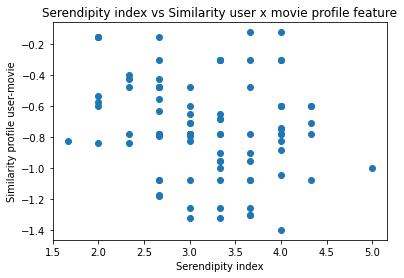

In [ ]:
plt.scatter( train_data[['numeric_siu']],np.log10(train_data[['sim_prof_ui']]))
plt.title("Serendipity index vs Similarity user x movie profile feature")
plt.xlabel("Serendipity index")
plt.ylabel("Similarity profile user-movie")
plt.show()

A decision tree is a non-linear model built by constructing many linear boundaries.

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, min_samples_split = 5, 
                           min_samples_leaf=2, max_features='sqrt',max_depth=1000,bootstrap=True)
# Train the model on training data
rf.fit(X_train_rf, y_train_rf)
# Use the forest's predict method on the test data
predictions = rf.predict(X_test_rf)

# Calculate the absolute errors
errors = abs(predictions - y_test_rf.values)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test_rf.values)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_rf.values.flatten(), predictions.flatten()))
print('Mean Squared Error:', metrics.mean_squared_error(y_test_rf.values.flatten(), predictions.flatten()))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_rf.values.flatten(), predictions.flatten())))

rf_prediction_results = pd.DataFrame({'Actual_Serendipity': y_test_rf.values.flatten(), 'Predicted_Serendipity': predictions.flatten()})
rf_prediction_results.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Mean Absolute Error: 0.69 degrees.
Accuracy: 74.35 %.
Mean Absolute Error: 0.6798423613382246
Mean Squared Error: 0.6443463388455962
Root Mean Squared Error: 0.802711865394798


,Actual_Serendipity,Predicted_Serendipity
0,3.666667,3.665254
1,3.333333,3.389210
2,4.333333,3.326429
3,2.666667,3.095217
4,2.666667,3.539603


**Feature Importance**

No handles with labels found to put in legend.


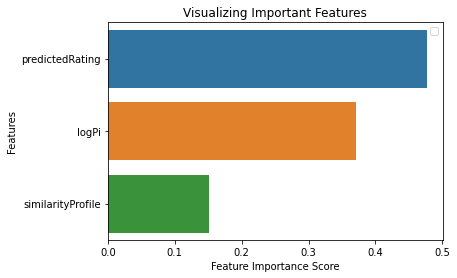

In [ ]:
   feature_imp = pd.Series(rf.feature_importances_,index=[['logpi_from_answers_csv', 'sim_prof_ui', 'predictedRating']]).sort_values(ascending=False)
   import matplotlib.pyplot as plt
   import seaborn as sns
   %matplotlib inline
   # Creating a bar plot\n,
   barplot = sns.barplot(x=feature_imp, y=feature_imp.index)
   barplot.set_yticklabels(['predictedRating', 'logPi', 'similarityProfile'])
   # Add labels to your graph\n,
   plt.xlabel('Feature Importance Score')
   plt.ylabel('Features')
   plt.title('Visualizing Important Features')
   plt.legend()
   plt.show()

## Optimization problem

---



**A.** We will recompute the features for all the users for the movies that have not seen - rated.

1.   Predicted Rating Feature
2.   Similarity user x movie profile
3.   Log popularity

**B.** We will predict the serendipity index with models:

1.   Logistic Regression
2.   Random Forest


### **A. Recompute Features for all users x movies**

**1. Predicted Rating**

For the estimation of the predicted rating for the rest of the unseen movies per user we will predict the ratings by using SVD factorization with the method of Gradient Descent for better estimations

In [ ]:
import numpy
import numpy as np
import pandas as pd
import progressbar as pb

def matrix_factorization(R, P, Q, K, steps=3500, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in pb.progressbar(range(steps)):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - numpy.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = numpy.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - numpy.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        if e < 0.001:
            break
    return P, Q.T

In [ ]:
# Initialize rating matrix with zeros 
ratings_matrix = filtered_answersdf.pivot(index='userId', columns='movieId', values='rating')
ratings_matrix = ratings_matrix.fillna(0)

In [ ]:
npMatrix = ratings_matrix.to_numpy()
#npMatrix = ratings_matrix.values

N = len(npMatrix)
M = len(npMatrix[0])
K = 2

P = numpy.random.rand(N,K)
Q = numpy.random.rand(M,K)

nP, nQ = matrix_factorization(npMatrix, P, Q, K)
nR = numpy.dot(nP, nQ.T)

In [ ]:
nR = np.load('predicted_ratings_gd.npy')

In [ ]:
predicted_ratings_df = pd.DataFrame(nR, index=ratings_matrix.index,  columns=ratings_matrix.columns)
predicted_ratings_df.head()

movieId,135,215,293,532,600,906,1214,1216,1246,1270,1416,1518,1729,1747,1889,2143,2161,2186,2360,2579,2700,2804,2810,2905,3994,3996,5464,6271,6509,6639,6708,6787,7206,7216,7324,7482,7618,7981,8752,8874,...,164179,164367,164540,164909,164917,164931,164949,164981,165105,165141,165337,165347,165421,165483,165549,165551,165937,166024,166149,166461,166486,166528,166558,166568,166635,166643,166705,166788,166918,166946,167018,167036,167038,167370,167544,167570,168026,168040,169912,170705
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100998,2.926714,2.103092,2.500715,2.908326,2.943898,2.938418,3.731223,2.670048,3.168100,2.098082,2.914805,3.187925,2.595583,2.368400,2.613968,2.986180,3.210522,3.519326,2.934451,2.491296,2.962056,3.611540,3.500043,2.249234,3.112211,3.794647,3.325267,3.145550,3.041425,3.667799,2.092665,1.930602,3.521097,2.881734,1.788483,3.353866,2.706469,3.334871,2.768083,1.776682,...,2.663981,3.141572,2.310505,3.399909,3.641196,2.885747,3.339126,3.434586,3.211522,3.253830,3.135255,2.920337,2.803924,3.380865,3.223138,3.786813,3.303980,3.530849,2.511843,3.217256,3.217608,2.541201,3.128036,3.447274,2.983617,3.241468,3.434657,3.443500,2.918171,2.481596,2.378398,3.009013,3.397462,2.847516,2.825425,4.229508,2.822490,1.456417,2.415338,3.007015
101049,3.511860,2.587615,3.016078,3.457373,3.431354,3.508438,4.461966,3.223920,3.751670,2.568585,3.476392,3.755735,3.139868,2.838691,3.166452,3.557994,3.808025,4.174058,3.514274,3.007681,3.486144,4.302776,4.086845,2.777343,3.730619,4.484863,3.940328,3.780016,3.667856,4.362833,2.567788,2.378048,4.152714,3.422988,2.194559,4.005619,3.234325,3.955801,3.263882,2.212713,...,3.232659,3.724711,2.820349,4.073783,4.280249,3.449607,3.928935,4.052311,3.760713,3.817923,3.716355,3.465082,3.361795,4.010645,3.865116,4.433910,3.930080,4.195176,3.026637,3.860169,3.858030,3.116719,3.737840,4.061781,3.553949,3.885299,4.056621,4.101054,3.516240,3.023669,2.857742,3.530820,4.051173,3.411621,3.402317,4.972233,3.369331,1.827887,2.929451,3.604456
101263,3.309216,2.628357,2.887704,3.161661,2.933270,3.254162,4.159243,3.097364,3.387300,2.571793,3.212948,3.332598,3.033896,2.665306,3.072363,3.277843,3.456582,3.788103,3.291104,2.888414,3.082828,3.963013,3.515784,2.849769,3.504000,4.022928,3.565277,3.578421,3.510666,3.997495,2.587964,2.423194,3.698351,3.121914,2.211848,3.718709,3.008360,3.591573,2.904531,2.324844,...,3.153133,3.376355,2.799747,3.821268,3.769337,3.211695,3.471383,3.613846,3.268039,3.341070,3.366177,3.149031,3.159726,3.642226,3.634868,3.851606,3.601005,3.829641,2.889369,3.636471,3.626856,3.137029,3.475888,3.605687,3.271156,3.648512,3.630440,3.772673,3.356761,2.985463,2.704190,3.090299,3.741582,3.199310,3.241594,4.379993,3.123080,1.960656,2.853021,3.385314
101318,4.005338,3.500352,3.571825,3.665207,3.046471,3.851682,4.958193,3.848778,3.851547,3.367027,3.783304,3.687064,3.798374,3.209884,3.867461,3.841704,3.962566,4.341345,3.949190,3.587162,3.391914,4.643073,3.692501,3.839921,4.222038,4.528109,4.067306,4.358915,4.340596,4.647686,3.415015,3.239125,4.115787,3.604763,2.918771,4.407329,3.575152,4.118805,3.228391,3.216534,...,3.996087,3.862574,3.627347,4.595813,4.119118,3.822058,3.814039,4.030471,3.492655,3.613153,3.846388,3.616520,3.810828,4.178391,4.387373,4.113715,4.186749,4.427951,3.559927,4.399831,4.375435,4.132984,4.129388,3.991916,3.828783,4.394863,4.071600,4.412261,4.135783,3.842272,3.292094,3.342817,4.401346,3.846373,3.983264,4.788724,3.693024,2.773101,3.608665,4.078716
101579,4.395952,3.931518,3.941737,3.977189,3.201781,4.202820,5.420348,4.252225,4.157284,3.766938,4.122569,3.949104,4.204339,3.518393,4.286504,4.180994,4.286774,4.696167,4.324695,3.962643,3.627184,5.052655,3.894203,4.324347,4.628421,4.873717,4.394182,4.791817,4.789635,5.047271,3.827601,3.641184,4.415705,3.907378,3.271422,4.810792,3.905226,4.456239,3.462428,3.643532,...,4.436360,4.176218,4.048259,5.035768,4.396120,4.176435,4.076922,4.326844,3.703014,3.844298,4.157365,3.914354,4.178652,4.521151,4.811

**2. Similarity profile user x movie**

In [ ]:
sim_prof_ui_full = pd.DataFrame(columns=('userId','movieId','sim_prof_ui') )
index = -1
unique_users = filtered_answersdf.userId.unique()
for user in unique_users:
    movies = filtered_answersdf.movieId.unique()
    for movie_i in movies:
        index = index + 1
        similarity_ij = 0
        for movie_j in movies_u:
            if movie_i != movie_j:
                similarity_ij = similarity_ij + sim_matrix_df.loc[int(movie_i), int(movie_j)]
            
        sim_prof_ui_full.loc[index] = [user, movie_i,similarity_ij/(len(movies_u))] 
sim_prof_ui_full.head()

,userId,movieId,sim_prof_ui
0,205229.0,108979.0,0.0000
1,205229.0,150548.0,0.2000
2,205229.0,164179.0,0.0000
3,205229.0,164981.0,0.2000
4,205229.0,162606.0,0.3335


**3. Log popularity**

In [ ]:
sim_prof_ui_full['logpi'] = pd.Series()
sim_prof_ui_full['logpi'] = np.where(sim_prof_ui_full.logpi.isna(),logpi[sim_prof_ui_full.movieId],0)
sim_prof_ui_full.head()

,userId,movieId,sim_prof_ui,logpi
0,205229.0,108979.0,0.0000,0.477121
1,205229.0,150548.0,0.2000,0.301030
2,205229.0,164179.0,0.0000,0.845098
3,205229.0,164981.0,0.2000,0.602060
4,205229.0,162606.0,0.3335,0.602060


Final data manipulations for the construction of the final dataset

In [ ]:
final_dataset = sim_prof_ui_full.merge(filtered_answersdf[['userId','movieId','predictedRating']],how='left',
                         left_on=['userId','movieId'],
                         right_on=['userId','movieId'])

In [ ]:
ratings_full = pd.DataFrame(nR, index=ratings_matrix.index,  columns=ratings_matrix.columns)
ratings_full.head()

for i in range(len(final_dataset)) : 
    if math.isnan(final_dataset.loc[i, "predictedRating"]):
#         print(final_dataset.loc[i, "predictedRating"])
        final_dataset.loc[i, "predictedRating"] = ratings_full.loc[final_dataset.loc[i, "userId"],final_dataset.loc[i, "movieId"]]

### **B. Predict Serendipity for all users x movies**

**1. Logistic Regression**

In [ ]:
final_dataset['serendipity_index'] = lrc.predict(final_dataset[['sim_prof_ui','logpi','predictedRating']])

In [ ]:
# Number of predicted serendipitous items
print("Number of unique predicted serendipitous movies ",final_dataset.movieId[final_dataset['serendipity_index']==True].unique().size)
final_dataset[final_dataset['serendipity_index']==True].head()

print("Dataset items :", final_dataset.movieId.size)
print("Predicted serendipitous items :", final_dataset[final_dataset.serendipity_index==True].movieId.size)

Number of unique predicted serendipitous movies  148
Dataset items : 47632
Predicted serendipitous items : 11971


**2. Random Forest**

In [ ]:
final_dataset['serendipity'] = rf.predict(final_dataset[['sim_prof_ui','logpi','predictedRating']])

errors = abs(final_dataset['serendipity'].values - y_test_rf.values)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test_rf.values)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.68 degrees.
Accuracy: 75.21 %.


In [ ]:
 feature_imp = pd.Series(rf.feature_importances_,index=[['logpi_from_answers_csv', 'sim_prof_ui', 'predictedRating']]).sort_values(ascending=False)
   import matplotlib.pyplot as plt
   import seaborn as sns
   %matplotlib inline
   # Creating a bar plot\n,
   barplot = sns.barplot(x=feature_imp, y=feature_imp.index)
   barplot.set_yticklabels(['predictedRating', 'logPi', 'similarityProfile'])
   # Add labels to your graph\n,
   plt.xlabel('Feature Importance Score')
   plt.ylabel('Features')
   plt.title('Visualizing Important Features')
   plt.legend()
   plt.show()

**Predicted Serendipity Results**

In [ ]:
final_dataset

,userId,movieId,sim_prof_ui,logpi,predictedRating,serendipity
0,205229.0,108979.0,0.0000,0.477121,4.882299,3.846043
1,205229.0,150548.0,0.2000,0.301030,4.428912,3.523190
2,205229.0,164179.0,0.0000,0.845098,4.290785,3.322261
3,205229.0,164981.0,0.2000,0.602060,3.462886,3.621523
4,205229.0,162606.0,0.3335,0.602060,4.076010,2.906672
...,...,...,...,...,...,...
47627,124322.0,166788.0,0.2500,0.000000,3.780921,3.075469
47628,124322.0,163134.0,0.1000,0.000000,3.317400,3.298588
47629,124322.0,162598.0,0.2500,0.000000,3.738661,3.089538
47630,124322.0,66371.0,0.2500,0.000000,3.116322,3.174920


### Optimization Setup

Methods

In [ ]:
def save_results(x, number_of_unique_items, number_of_unique_users):
    # Save output in np array
    result = np.zeros((number_of_unique_items, number_of_unique_users))
    for i in range(number_of_unique_items):
        result[i][:]= x[i][:].value
        
    return result

def plot_number_of_recommendations_per_movie(result):
    plt.figure()
    plt.plot(range(0,result.shape[0]),np.sum(result,axis=1))
    plt.xlabel("Movie Id")
    plt.ylabel("Number of recommendations")
    plt.title("Number of recommendations per movie")
    

def check_constraints(categoryxitems, siu_array, result, Ls, theta, linear=True):
    # Check of first constring
    if np.sum(np.linalg.norm(np.sum(result, axis=0)-Ls))>0.01:
        print("First Constraint not met",(np.sum(result, axis=0) == Ls))
    else:
        print("First Constraint met")
    
    # Check second constraint
    if linear:
        check_second_constraint_linear(categoryxitems, siu_array, result, Ls, theta)
    else:
        check_second_constraint_quadratic(categoryxitems, siu_array, result, Ls, theta)

        
def check_second_constraint_linear(categoryxitems, siu_array, result, Ls, theta):
    for index in range(len(categoryxitems)):
        ser = np.sum(np.multiply(siu_array[categoryxitems[index],:],result[categoryxitems[index],:]))/categoryxitems[index].size
        if (ser<theta):
            comp = " ,less than"
        else:
            comp = " ,greater/equal "

        print("Serendipity of category ", index, " : ",ser, comp, "than threshold theta = ",theta)    
        
def check_second_constraint_quadratic(categoryxitems, siu_array, result, Ls, theta):
    
    for index in range(len(categoryxitems)):
        dissim_array_per_category = np.zeros((categoryxitems[index].size,number_of_unique_users))
        for u in range(number_of_unique_users):
            dissim_array_per_category[:,u] = np.sum(np.multiply(np.reshape(result[categoryxitems[index],u],(categoryxitems[index].size,1))@np.reshape(result[:,u],(1,number_of_unique_items)),dissim_matrix[categoryxitems[index],:]),axis=1)
            
        ser = np.sum(np.multiply(siu_array[categoryxitems[index],:],result[categoryxitems[index],:])+dissim_array_per_category)/categoryxitems[index].size    
        if (ser<theta):
            comp = " ,less than"
        else:
            comp = " ,greater/equal "
               
        print("Serendipity of category ", index, " : ",ser, comp, "than threshold theta = ",theta)

        
def plot_number_of_recommendations_per_movie(result, Ls, theta):
    plt.figure()
    plt.plot(range(0,result.shape[0]),np.sum(result,axis=1))
    plt.xlabel("Movie Id")
    plt.ylabel("Number of recommendations")
    plt.title("Number of recommendations per movie, Ls=" + str(Ls[0]) + " ,theta=" + str(theta))

    
def plot_number_of_rec_per_movie_for_all_thetas(result, thetas, Lss):
    figure = plt.figure(figsize=(18,6))
    figure.subplots_adjust(hspace=0.4)
    l=0
    for Ls in Lss:
        plt.subplot(1, Lss.shape[0], l + 1)
        for i in range(len(thetas[l])):
            lab = "theta = " + str(thetas[l][i])
            plt.plot(range(0,result[:,:,i,l].shape[0]),np.sum(result[:,:,i,l],axis=1), label=lab)
        plt.xlabel("Movie Id")
        plt.ylabel("Number of recommendations")
        plt.title("Number of recommendations per movie, Ls=" + str(Ls[0]))
        plt.legend()
        l = l +1

    
def plot_total_serendipity_vs_theta(result, siu_array, Lss, thetas, number_of_unique_users):
    figure = plt.figure(figsize=(18,6))
    figure.subplots_adjust(hspace=0.4)
    l=0
    for Ls in Lss:
        plt.subplot(1, Lss.shape[0], l + 1)
        for i in range(len(thetas[l])):
            total_serendipity = np.sum(np.multiply(siu_array,result[:,:,i,l]))
            lab = "theta = " + str(thetas[l][i])
            plt.bar(thetas[l][i],total_serendipity, width=0.3)
        plt.xlabel("Theta")
        plt.ylabel("Total Serendipity")
        plt.title("Total Serendipity for different thetas, Ls=" + str(Ls[0]))
        l = l +1
    

def plot_serendipity_per_category(result, siu_array, categoryxitems, Lss, thetas, number_of_unique_users, linear=True):
    colors=np.array(['b','r','g','y'])
#     colors=np.array([0.3,0.4,0.6,0.8,1.0,1.2,1.4])
    #figure = plt.figure(figsize=(18,8))
    #figure.subplots_adjust(hspace=0.4)
    l=0
    for Ls in Lss:
#         ax.subplot(1, Lss.shape[0], l + 1)
        fig, ax = plt.subplots()
        fig.set_figheight(8)
        fig.set_figwidth(12)
        step=-0.5
        for i in range(len(thetas[l])):
            added=0
            step = step+0.3 
            if linear:
                for index in range(len(categoryxitems)):
                    ser = np.sum(np.multiply(siu_array[categoryxitems[index],:],result[categoryxitems[index],:,i,l]))/categoryxitems[index].size

                    if added==1:
                        ax.bar(index+step, ser, width=0.3, color=colors[i])
                    else:
                        lab = "theta = " + str(thetas[l][i])
                        ax.bar(index+step, ser, width=0.3, color=colors[i],label=lab)
                        added = added + 1
            else:
                for index in range(len(categoryxitems)):
                    dissim_array_per_category = np.zeros((categoryxitems[index].size,number_of_unique_users))
                    for u in range(number_of_unique_users):
                        dissim_array_per_category[:,u] = np.sum(np.multiply(np.reshape(result[categoryxitems[index],u,i,l],(categoryxitems[index].size,1))@np.reshape(result[:,u,i,l],(1,number_of_unique_items)),dissim_matrix[categoryxitems[index],:]),axis=1)
            
                    ser = np.sum(np.multiply(siu_array[categoryxitems[index],:],result[categoryxitems[index],:,i,l])+dissim_array_per_category)/categoryxitems[index].size    
                
                    if added==1:
                        ax.bar(index+step, ser, width=0.3, color=colors[i])
                    else:
                        lab = "theta = " + str(thetas[l][i])
                        ax.bar(index+step, ser, width=0.3, color=colors[i],label=lab)
                        added = added + 1
        
        ax.set_xlabel("Category")
        ax.set_ylabel("Serendipity")
        ax.set_title("Serendipity per category for different thetas, Ls=" + str(Ls[0]))
        ax.legend()
        l = l +1

def find_max_dim_of_theta(thetas):
    max_dim=0
    for i in thetas:
        if (len(i)>max_dim):
            max_dim=len(i)
    return max_dim


def optimize(dissim_matrix, siu_array, number_of_unique_items, booleanX, categoryxitems, Lss, thetas, defaultSolver=True, sol="ECOS"):
    max_dim = find_max_dim_of_theta(thetas)
    result_x_dij = np.zeros((number_of_unique_items, number_of_unique_users, max_dim, Lss.shape[0]))
    l=0
    for Ls in Lss: 
        i=0
        for theta in thetas[l]:
            print("\nOPTIMIZATION problem with X binary = ",booleanX, " Ls = ", Ls[0], "theta = ", theta)
            
            dissim_array = np.zeros((number_of_unique_items,number_of_unique_users))
            x = cp.Variable((number_of_unique_items,number_of_unique_users), boolean=booleanX)
            
            if dissim_matrix is None: 
                print('dissim_matrix is None')
                dissim_array = 0 
            else:
                print('dissim_matrix is not None')
                for u in range(number_of_unique_users):
                    dissim_array[:,u] = cp.sum(cp.multiply(cp.reshape(x[:,u],(number_of_unique_items,1))*cp.reshape(x[:,u],(1,number_of_unique_items)),dissim_matrix),axis=0).value  

            objective = cp.Maximize(cp.sum(cp.multiply(siu_array,x)+dissim_array)/number_of_unique_users)
            print(objective.parameters)
            # First constraint
            constraints = [0.<= x, 
                          x <= 1.,
                          cp.sum(x, axis=0) == Ls]

            # Second constraint
            if dissim_matrix is None:
                for index in range(len(categoryxitems)):
                    constraints.append((cp.sum(cp.multiply(siu_array[categoryxitems[index],:],x[categoryxitems[index],:]))/categoryxitems[index].size>=theta))
            else: 
                for index in range(len(categoryxitems)):
                    dissim_array_per_category = '{}_{}'.format("dissim_array_per_category", index)
                    #print("Name = ", dissim_array_per_category)
                    dissim_array_per_category = np.zeros((categoryxitems[index].size,number_of_unique_users))
                    for u in range(number_of_unique_users):
                        dissim_array_per_category[:,u] = cp.sum(cp.multiply(cp.reshape(x[categoryxitems[index],u],(categoryxitems[index].size,1))@cp.reshape(x[:,u],(1,number_of_unique_items)),dissim_matrix[categoryxitems[index],:]),axis=1).value
                    constraints.append((cp.sum(cp.multiply(siu_array[categoryxitems[index],:],x[categoryxitems[index],:])+dissim_array_per_category)/categoryxitems[index].size>=theta))
        
            if defaultSolver:
                prob = cp.Problem(objective, constraints).solve(verbose=True)
            else: 
                prob = cp.Problem(objective, constraints).solve(solver=sol, verbose=True)

            # The optimal value for x is stored in `x.value`.
            print(x.value)
            print("\n")

            # Save results
            result_x_dij[:,:,i,l] = save_results(x, number_of_unique_items, number_of_unique_users)

            # Check constraints
            if dissim_matrix is None: 
                check_constraints(categoryxitems, siu_array, result_x_dij[:,:,i,l], Ls, theta, linear=True)
            else:
                check_constraints(categoryxitems, siu_array, result_x_dij[:,:,i,l], Ls, theta, linear=False)

            # Plot results
            plot_number_of_recommendations_per_movie(result_x_dij[:,:,i,l], Ls, theta)

            print("\n")
            i = i + 1
        
        l=l+1

    return result_x_dij

Create siu matrix

In [ ]:
siu = final_dataset.pivot(index='movieId',columns='userId',values='serendipity')
siu_array = np.asarray(siu)
siu_array

array([[3.23695004, 3.50257386, 3.31591146, ..., 3.36445605, 3.33598725,
        3.5373641 ],
       [3.20157514, 3.20428625, 3.20428625, ..., 3.25598525, 3.11489858,
        3.38564297],
       [3.29041788, 3.22522133, 3.25055136, ..., 3.00843813, 3.26307847,
        3.13413608],
       ...,
       [3.01893729, 3.01893729, 3.01893729, ..., 3.02058801, 3.01893729,
        3.11372375],
       [3.23507341, 3.20804484, 3.2148496 , ..., 3.49989527, 3.24009794,
        3.03893001],
       [3.20824279, 3.24002811, 3.24489584, ..., 3.40037465, 3.28962896,
        3.47421887]])

Limit continuous values at 2 decimals

In [ ]:
siu_array = np.around(siu_array, decimals=2)
siu_array

array([[3.24, 3.5 , 3.32, ..., 3.36, 3.34, 3.54],
       [3.2 , 3.2 , 3.2 , ..., 3.26, 3.11, 3.39],
       [3.29, 3.23, 3.25, ..., 3.01, 3.26, 3.13],
       ...,
       [3.02, 3.02, 3.02, ..., 3.02, 3.02, 3.11],
       [3.24, 3.21, 3.21, ..., 3.5 , 3.24, 3.04],
       [3.21, 3.24, 3.24, ..., 3.4 , 3.29, 3.47]])

Set parameters for the optimization problem

In [ ]:
number_of_unique_users = len(unique_users)
number_of_unique_items = siu.index.size
items = number_of_unique_items 
categoryxitems = np.array_split(range(number_of_unique_items), 5)
thetas = np.array([[1, 2],
                   [1, 2, 3]])
Lss = np.array([[2] * number_of_unique_users,
                [3] * number_of_unique_users])

thetas_bool = np.array([[2, 4],[4, 6]])
thetas_cont = np.array([[2, 4],[6, 8]])

thetas_quadratic = np.array([[4 , 6],[10, 14]])

Lss_quad = np.array([[3] * number_of_unique_users,
                [4] * number_of_unique_users])

Minimum average amount of serendipity required for items per category with dij=0

In [ ]:
Sc = []
for c in categoryxitems:
    Sc.append(np.average(np.average(siu_array[c,:],axis=1)))
Sc

[3.2473181438127092,
 3.2553856605351172,
 3.2506720317725746,
 3.285952132107024,
 3.2715534188034194]

### Optimization

**A. Optimization where dij == 0 (linear problem)**

x is boolean


OPTIMIZATION problem with X binary =  True  Ls =  2 theta =  2
dissim_matrix is None
<bound method Canonical.parameters of Maximize(Expression(AFFINE, NONNEGATIVE, ()))>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


First Constraint met
Serendipity of category  0  :  4.933695652173912  ,greater/equal  than threshold theta =  2
Serendipity of category  1  :  12.394130434782609  ,greater/equal  than threshold theta =  2
Serendipity of category  2  :  7.860434782608697  ,greater/equal  than threshold theta =  2
Serendipity of category  3  :  3.412826086956522  ,greater/equal  than threshold theta =  2
Serendipity of category  4  :  6.478888888888889  ,greater/equal  than threshold theta =  2



OPTIMIZATION problem with X binary =  True  Ls =  2 theta =  4
dissim_matrix is None
<bound method Canonical.parameters of Maximize(Expression(AFFINE, NONNEGATIVE, ()))>
[[0. 0. 0. ... 0

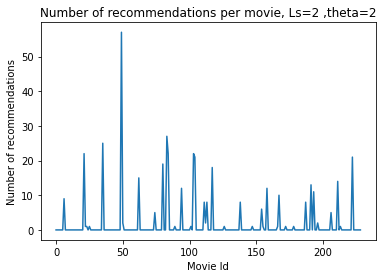

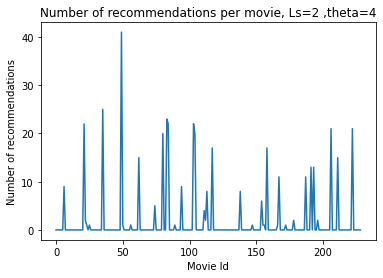

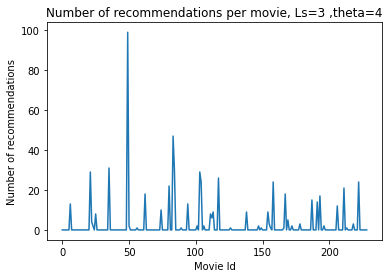

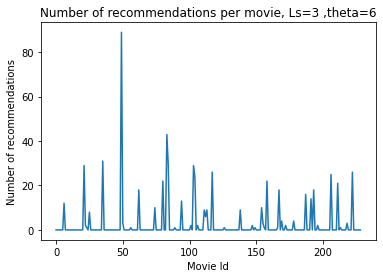

In [ ]:
results_x_boolean_dij_0 = optimize(None, siu_array, number_of_unique_items, True, categoryxitems, Lss, thetas_bool, True)

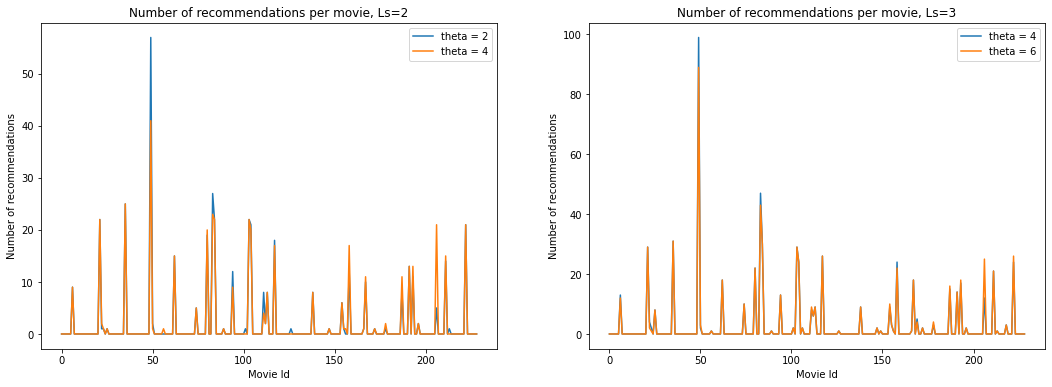

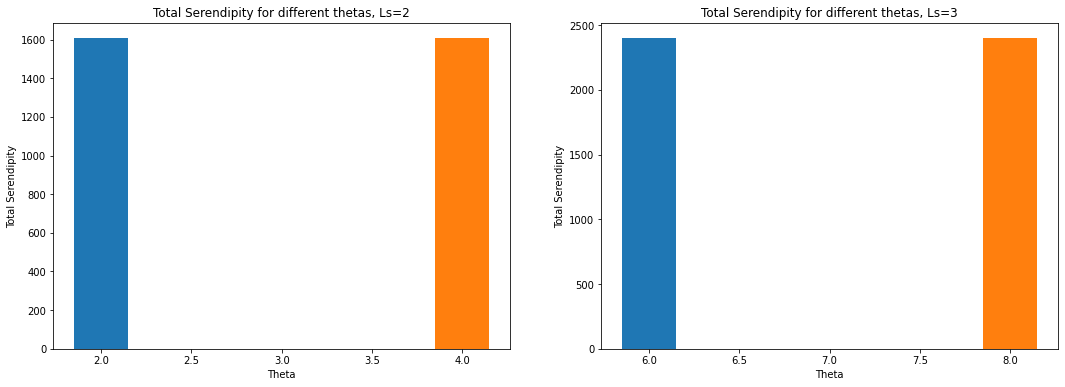

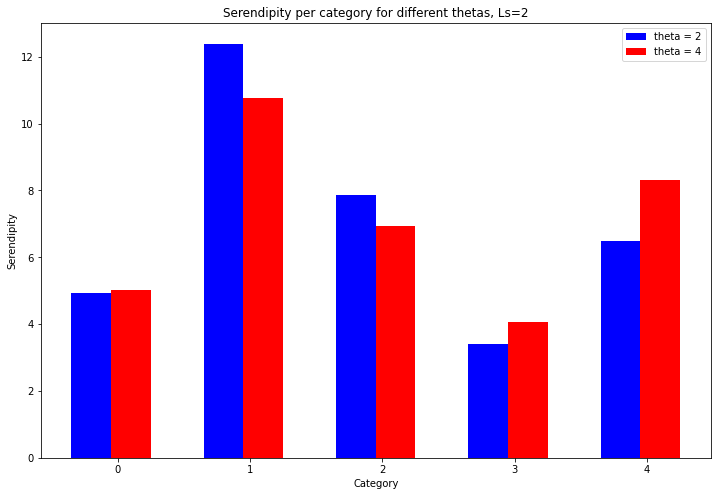

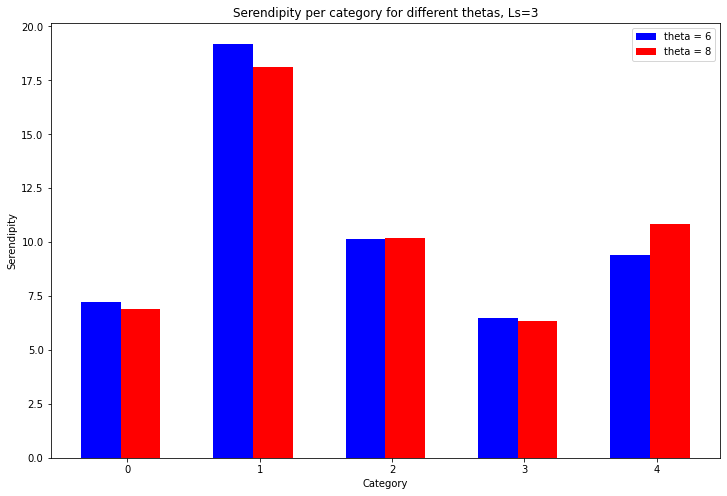

In [ ]:
plot_number_of_rec_per_movie_for_all_thetas(results_x_boolean_dij_0, thetas_bool, Lss)
plot_total_serendipity_vs_theta(results_x_boolean_dij_0, siu_array, Lss, thetas_cont, number_of_unique_users)
plot_serendipity_per_category(results_x_boolean_dij_0, siu_array, categoryxitems, Lss, thetas_cont, number_of_unique_users, linear=True)    

X is continuous


OPTIMIZATION problem with X binary =  False  Ls =  2 theta =  2
dissim_matrix is None
<bound method Canonical.parameters of Maximize(Expression(AFFINE, UNKNOWN, ()))>

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.675e+00  -4.864e+04  +2e+05  5e-01  4e-01  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  -8.960e+00  -1.589e+04  +8e+04  2e-01  1e-01  2e+00  8e-01  0.9890  5e-01   1  1  1 |  0  0
 2  -6.823e+00  -1.217e+03  +9e+03  1e-02  1e-02  4e-01  9e-02  0.9183  3e-02   2  1  1 |  0  0
 3  -6.617e+00  -1.268e+02  +1e+03  1e-03  2e-03  9e-03  1e-02  0.8740  6e-03   1  1  1 |  0  0
 4  -6.600e+00  -1.087e+01  +5e+01  3e-05  1e-03  7e-04  5e-04  0.9644  1e-02   1  0  0 |  0  0
 5  -6.714e+00  -9.348e+00  +3e+01  2e-05  1e-03  3e-04  3e-04  0.5180  3e-01   1  1  1 |  0  0
 6  -6.781e+00  -9.381e+00  +3e+01  2e-05  1e-03  3e-04  3e-04  0.1006

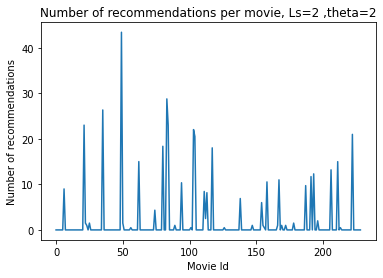

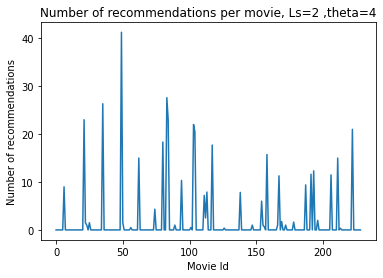

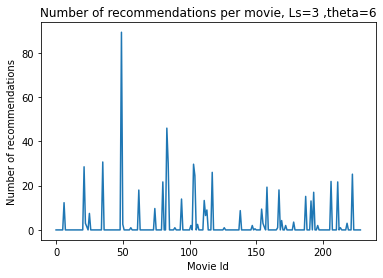

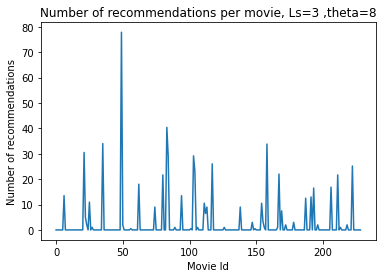

In [ ]:
results_x_continuous_dij_0 = optimize(None, siu_array, number_of_unique_items, False, categoryxitems, Lss, thetas_cont)

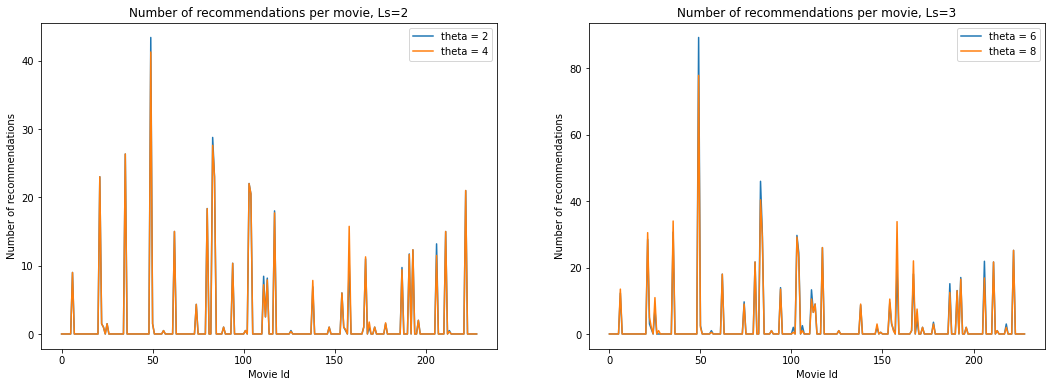

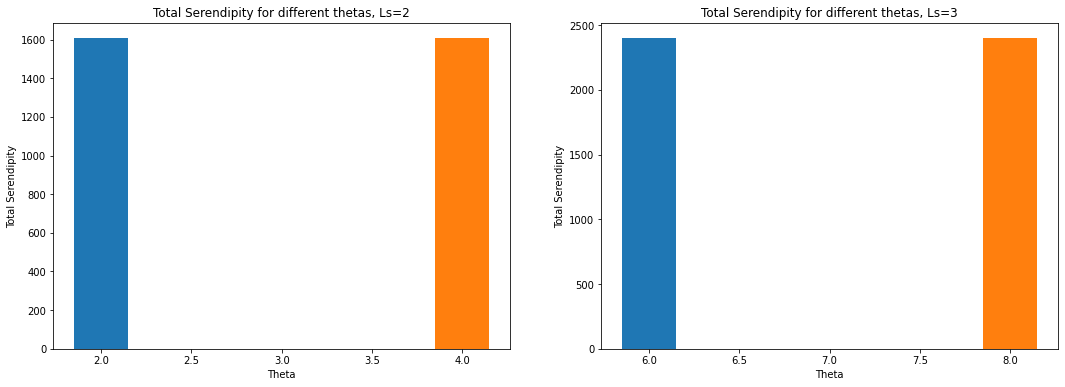

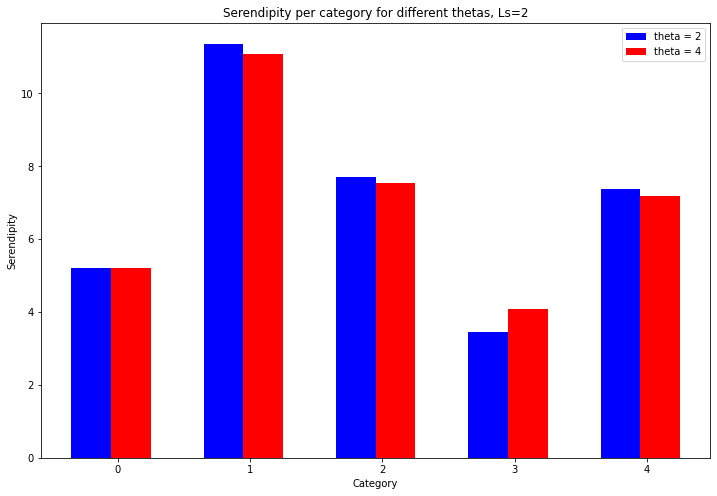

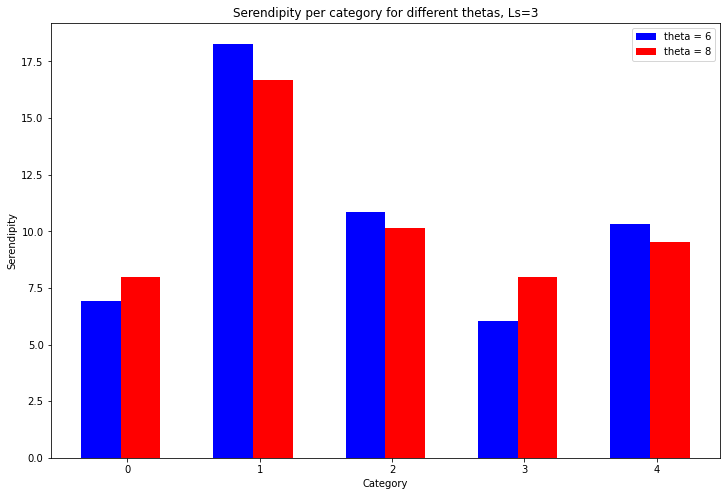

In [ ]:
plot_number_of_rec_per_movie_for_all_thetas(results_x_continuous_dij_0, thetas_cont, Lss)
plot_total_serendipity_vs_theta(results_x_continuous_dij_0, siu_array, Lss, thetas_cont, number_of_unique_users)
plot_serendipity_per_category(results_x_continuous_dij_0, siu_array, categoryxitems, Lss, thetas_cont, number_of_unique_users, linear=True)    

**A. Optimization where dij <> 0 (quadratic problem)**

x is boolean


OPTIMIZATION problem with X binary =  True  Ls =  3 theta =  4
dissim_matrix is not None
<bound method Canonical.parameters of Maximize(Expression(AFFINE, UNKNOWN, ()))>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


First Constraint met
Serendipity of category  0  :  10.782804347826087  ,greater/equal  than threshold theta =  4
Serendipity of category  1  :  28.5924347826087  ,greater/equal  than threshold theta =  4
Serendipity of category  2  :  16.551  ,greater/equal  than threshold theta =  4
Serendipity of category  3  :  7.709347826086956  ,greater/equal  than threshold theta =  4
Serendipity of category  4  :  13.380866666666666  ,greater/equal  than threshold theta =  4



OPTIMIZATION problem with X binary =  True  Ls =  3 theta =  6
dissim_matrix is not None
<bound method Canonical.parameters of Maximize(Expression(AFFINE, UNKNOWN, ()))>
[[0. 0. 0. ... 0. 0. 0.]
 [

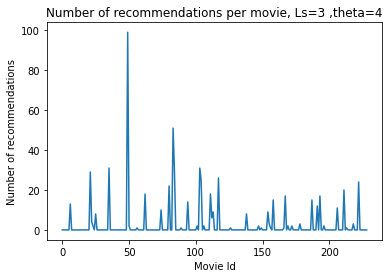

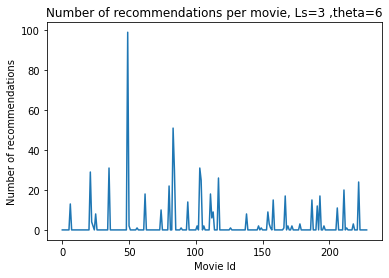

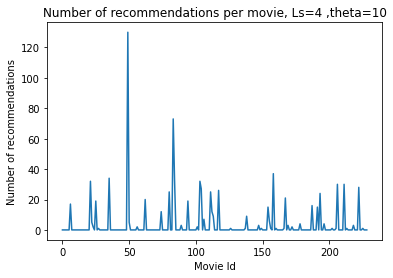

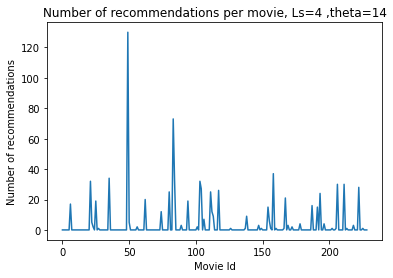

In [ ]:
results_x_boolean_dij_notzero = optimize(dissim_matrix, siu_array, number_of_unique_items, True, categoryxitems, Lss_quad, thetas_quadratic)

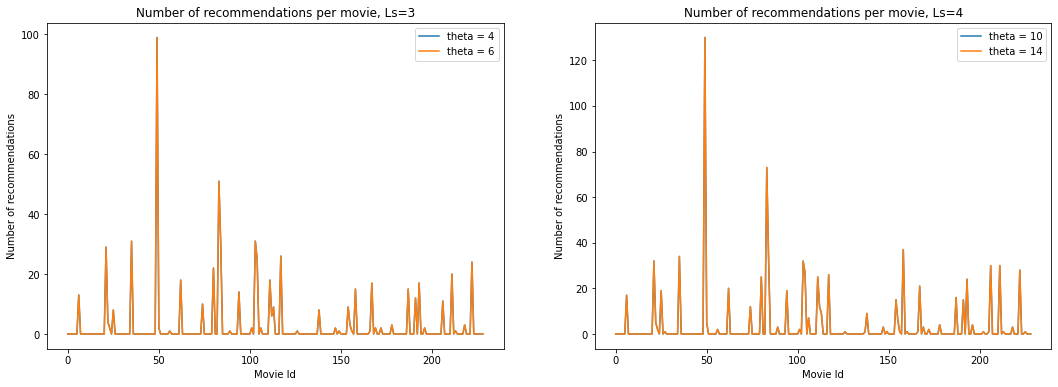

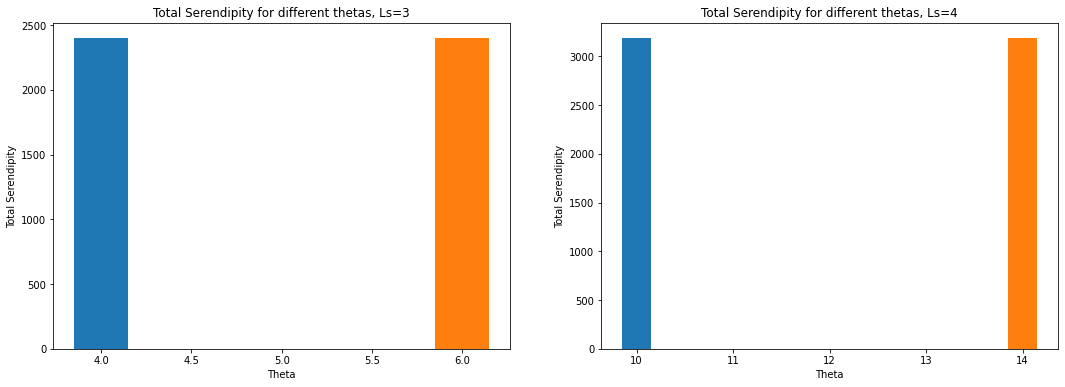

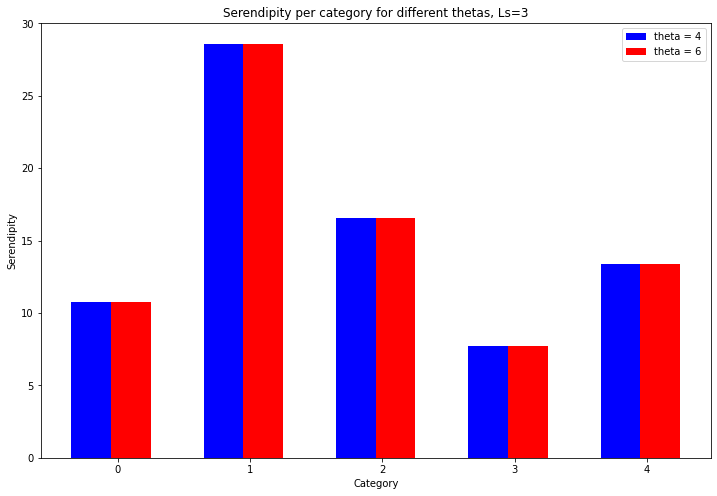

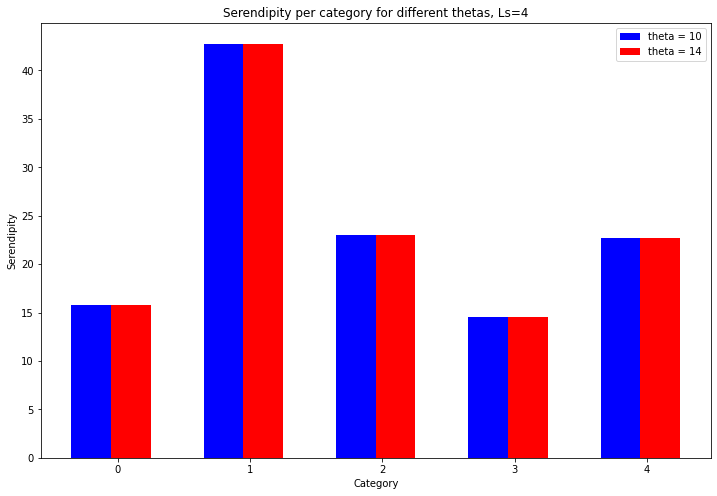

In [ ]:
plot_number_of_rec_per_movie_for_all_thetas(results_x_boolean_dij_notzero, thetas_quadratic, Lss_quad)
plot_total_serendipity_vs_theta(results_x_boolean_dij_notzero, siu_array, Lss_quad, thetas_quadratic, number_of_unique_users)
plot_serendipity_per_category(results_x_boolean_dij_notzero, siu_array, categoryxitems, Lss_quad, thetas_quadratic, number_of_unique_users, linear=False)    

x is continuous

In [ ]:
results_x_continuous_dij_notzero = optimize(dissim_matrix, siu_array, number_of_unique_items, False, categoryxitems, Lss, thetas, False, 'SCS')

In [ ]:
plot_number_of_rec_per_movie_for_all_thetas(results_x_continuous_dij_notzero, thetas, Lss)
plot_total_serendipity_vs_theta(results_x_continuous_dij_notzero, siu_array, Lss, thetas, number_of_unique_users)
plot_serendipity_per_category(results_x_continuous_dij_notzero, siu_array, categoryxitems, Lss, thetas, number_of_unique_users, linear=False)    

#### Check results for specific users

In [ ]:
selected_user=101263   # give user id
print("The movies user ", selected_user, " has already rated are: \n", filtered_answersdf[filtered_answersdf.userId==selected_user].movieId.values)

The movies user  101263  has already rated are: 
 [165347 162602]


In [ ]:
# transform results array to dataframe
theta=1
Ls=1
result_dataframe = pd.DataFrame(results_x_boolean_dij_0[:,:,theta,Ls], index=siu.index, columns = siu.columns) # set the result array you want
result_dataframe.head()

userId,100998.0,101049.0,101263.0,101318.0,101579.0,101799.0,101889.0,102355.0,103266.0,105111.0,105520.0,106883.0,107522.0,107695.0,107868.0,108419.0,108987.0,109289.0,109335.0,109384.0,109763.0,110077.0,110343.0,110386.0,110525.0,110988.0,111527.0,111751.0,111869.0,112139.0,112600.0,112947.0,113138.0,113394.0,113401.0,113591.0,113679.0,114855.0,114952.0,115551.0,...,180779.0,181079.0,181252.0,184692.0,184994.0,185875.0,189494.0,189816.0,190450.0,191612.0,192284.0,192643.0,193483.0,196271.0,196423.0,196794.0,197102.0,198287.0,198327.0,199727.0,199760.0,200352.0,200592.0,201025.0,201027.0,201672.0,201960.0,202808.0,202953.0,204104.0,204589.0,205229.0,205356.0,206030.0,206188.0,206190.0,206330.0,206504.0,206554.0,206808.0
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
532.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
result_dataframe = pd.DataFrame(results_x_continuous_dij_0[:,:,theta,Ls], index=siu.index, columns = siu.columns) # set the result array you want
result_dataframe.head()

userId,100998.0,101049.0,101263.0,101318.0,101579.0,101799.0,101889.0,102355.0,103266.0,105111.0,105520.0,106883.0,107522.0,107695.0,107868.0,108419.0,108987.0,109289.0,109335.0,109384.0,109763.0,110077.0,110343.0,110386.0,110525.0,110988.0,111527.0,111751.0,111869.0,112139.0,112600.0,112947.0,113138.0,113394.0,113401.0,113591.0,113679.0,114855.0,114952.0,115551.0,...,180779.0,181079.0,181252.0,184692.0,184994.0,185875.0,189494.0,189816.0,190450.0,191612.0,192284.0,192643.0,193483.0,196271.0,196423.0,196794.0,197102.0,198287.0,198327.0,199727.0,199760.0,200352.0,200592.0,201025.0,201027.0,201672.0,201960.0,202808.0,202953.0,204104.0,204589.0,205229.0,205356.0,206030.0,206188.0,206190.0,206330.0,206504.0,206554.0,206808.0
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135.0,3.400053e-11,4.265678e-11,2.188200e-11,4.282188e-11,2.751030e-11,3.273771e-11,2.808056e-11,4.057034e-11,2.599494e-11,2.241732e-11,2.281816e-11,2.730381e-11,1.438539e-11,2.889821e-11,1.801753e-11,2.220388e-11,2.228364e-11,3.058117e-11,1.071309e-11,2.515502e-11,1.112469e-11,1.963425e-11,2.440378e-11,2.760418e-11,1.851600e-11,2.511439e-11,1.099897e-11,1.966740e-11,3.187611e-11,4.249926e-11,3.052834e-11,2.222296e-11,3.094474e-11,2.799142e-11,1.148355e-11,2.723815e-11,2.905671e-11,1.171183e-11,3.791498e-11,3.091431e-11,...,2.562540e-11,1.337540e-11,1.493942e-11,1.703805e-11,4.845352e-11,2.127696e-11,2.745304e-11,1.523086e-11,2.337573e-11,3.279962e-11,2.235456e-11,2.406651e-11,8.220962e-11,1.581044e-11,4.512197e-11,2.443216e-11,2.729813e-11,2.013148e-11,2.445252e-11,2.513649e-11,1.894199e-11,2.352218e-11,1.575485e-11,1.893929e-11,1.496075e-11,2.828751e-11,2.133989e-11,2.465680e-11,3.097516e-11,1.132246e-11,1.132788e-11,3.540412e-11,1.858054e-11,2.466960e-11,1.729610e-11,4.240734e-11,2.880410e-11,1.928371e-11,2.523986e-11,4.115615e-11
215.0,2.980421e-11,1.834293e-11,1.721040e-11,2.639709e-11,1.692155e-11,1.230035e-11,1.392683e-11,2.014861e-11,1.506561e-11,1.419508e-11,1.202463e-11,1.525064e-11,1.529556e-11,1.626287e-11,1.706325e-11,1.651210e-11,1.656171e-11,1.649177e-11,1.460422e-11,1.548728e-11,1.403587e-11,1.660223e-11,2.118313e-11,1.193210e-11,1.751011e-11,1.453944e-11,1.537851e-11,1.507141e-11,1.779958e-11,2.368287e-11,2.118320e-11,1.055783e-11,1.161409e-11,1.951183e-11,1.286137e-11,1.876854e-11,1.301757e-11,1.390709e-11,1.679769e-11,1.416266e-11,...,1.945013e-11,1.577879e-11,1.406776e-11,1.833131e-11,1.793282e-11,1.548253e-11,1.268579e-11,1.454278e-11,1.202822e-11,1.453711e-11,1.070687e-11,1.071774e-11,2.300612e-11,1.530964e-11,3.175559e-11,2.031946e-11,2.039436e-11,1.306318e-11,1.623422e-11,1.186377e-11,1.509999e-11,1.060879e-11,1.919666e-11,1.123111e-11,1.496075e-11,1.134922e-11,2.182127e-11,1.554447e-11,1.083424e-11,1.435227e-11,1.920655e-11,2.001484e-11,1.323910e-11,1.025863e-11,1.291075e-11,3.133929e-11,1.650785e-11,1.607865e-11,1.577482e-11,2.509757e-11
293.0,4.127075e-11,1.945067e-11,1.889120e-11,2.215648e-11,2.141867e-11,1.199419e-11,1.131375e-11,2.768578e-11,1.506561e-11,2.831751e-11,1.354405e-11,2.177424e-11,1.887519e-11,2.652049e-11,1.706325e-11,1.951362e-11,2.894971e-11,1.948420e-11,1.964669e-11,2.451751e-11,1.641837e-11,1.782591e-11,2.570718e-11,2.760418e-11,2.138117e-11,2.172914e-11,2.769706e-11,1.071920e-11,1.686811e-11,3.358879e-11,1.543975e-11,3.068651e-11,1.925026e-11,2.508363e-11,1.784935e-11,2.329520e-11,2.089786e-11,1.914325e-11,1.497377e-11,1.962536e-11,...,1.294266e-11,2.740172e-11,2.071108e-11,2.433306e-11,1.976343e-11,1.843652e-11,1.460435e-11,2.126253e-11,1.336067e-11,2.649888e-11,1.284699e-11,1.339765e-11,2.685269e-11,2.050161e-11,2.390303e-11,2.121203e-11,2.809070e-11,2.013148e-11,2.033510e-11,2.513649e-11,1.637820e-11,1.322787e-11,2.282086e-11,1.305532e-11,2.031138e-11,1.853579e-11,2.902442e-11,1.161668e-11,1.751732e-11,1.685336e-11,2.337882e-11,1.503480e-11,1.534036e-11,1.339398e-11,1.827489e-11,3.744201e-11,1.142638e-11,1.135257e-11,2.088306e-11,1.497990e-11
532.0,3.176406e-11,2.162729e-1

In [ ]:
result_dataframe = pd.DataFrame(results_x_boolean_dij_notzero[:,:,theta,Ls], index=siu.index, columns = siu.columns) # set the result array you want
result_dataframe.head()

userId,100998.0,101049.0,101263.0,101318.0,101579.0,101799.0,101889.0,102355.0,103266.0,105111.0,105520.0,106883.0,107522.0,107695.0,107868.0,108419.0,108987.0,109289.0,109335.0,109384.0,109763.0,110077.0,110343.0,110386.0,110525.0,110988.0,111527.0,111751.0,111869.0,112139.0,112600.0,112947.0,113138.0,113394.0,113401.0,113591.0,113679.0,114855.0,114952.0,115551.0,...,180779.0,181079.0,181252.0,184692.0,184994.0,185875.0,189494.0,189816.0,190450.0,191612.0,192284.0,192643.0,193483.0,196271.0,196423.0,196794.0,197102.0,198287.0,198327.0,199727.0,199760.0,200352.0,200592.0,201025.0,201027.0,201672.0,201960.0,202808.0,202953.0,204104.0,204589.0,205229.0,205356.0,206030.0,206188.0,206190.0,206330.0,206504.0,206554.0,206808.0
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
532.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# find best 3 recommendations, note that only the 'Ls' first are valid
best_recommendations_by_user = pd.DataFrame(columns=siu.columns) #
for u in unique_users:
    best_recommendations_by_user[u] = result_dataframe.loc[:,u].sort_values(ascending=False).index[[0,1,2]]
    
print("The best 3 recommendations for user ",selected_user, " are:\n", best_recommendations_by_user.loc[:,selected_user].values)
print("\n Keep only the first Ls out of them!!")

The best 3 recommendations for user  101263  are:
 [109633.   1214.  52885.]

 Keep only the first Ls out of them!!


In [ ]:
print("The position of a movie in the normanized range [0, number of movies] is :", np.where(siu.index == 52885)[0][0]) # set the movie id you want to check

The position of a movie in the normanized range [0, number of movies] is : 49
